In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg

In [2]:
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('data/train/train.csv')

In [7]:
df['GHI'] = df['DHI']+df['DNI']

In [8]:
x = df[['DHI','DNI','GHI','WS','RH','T'] ]
y = df[['TARGET']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

In [9]:
# from sklearn.linear_model import LinearRegression

mlr = linear_model.LinearRegression()
mlr.fit(x_train, y_train) 

LinearRegression()

In [10]:
y_predict = mlr.predict(x_test)

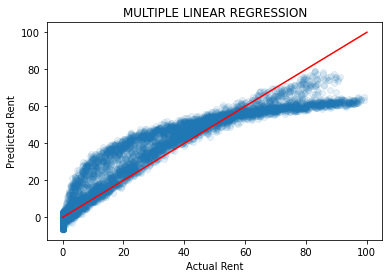

In [34]:
plt.scatter(y_test, y_predict, alpha=0.1)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.plot([0,100],[0,100],color='red')
plt.show()

In [27]:
mlr.coef_
# x_train.columns
for col,coef in zip(x_train.columns,list(mlr.coef_[0]) ):
    print(f"{col} : {coef}")


DHI : -45941218136.84205
DNI : -45941218136.89887
GHI : 45941218136.94775
WS : -0.03160503404131179
RH : -0.024613908358411075
T : 0.22666183933795164


### validate coefficients 